In [1]:
import sys 
import os
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import astropy.constants as c
import astropy.units as u
from astropy.io import fits
from IPython.display import display
import logging
from pathlib import Path
from datetime import datetime
# import pyregion
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.coordinates import SkyCoord
import importlib
import pickle
import pandas as pd
try:
    logging.getLogger('matplotlib').disabled = True
except:
    pass
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)
import shutil
from astropy.table import QTable, Table
from matplotlib.patches import (Ellipse, Rectangle)
import matplotlib.patches as mpatches
import itertools
import shapely
import shapely.plotting
from shapely.geometry.point import Point
from shapely import affinity
from scipy.integrate import dblquad
from uncertainties import ufloat
from scipy.optimize import curve_fit
from astropy.visualization import (
    MinMaxInterval, 
    SqrtStretch,
    ImageNormalize,
    simple_norm
)
from astropy import visualization
import matplotlib.cm as cm
from pprint import pprint
import pylustrator
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models
from astropy.convolution.kernels import CustomKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.utils._parameters import as_pair
from astropy.convolution import discretize_model
from pathlib import Path

# with open('imports.py','w') as file:
#     file.write(_ih[-1])
# !pipreqs .

In [2]:
ROOT_DIR = os.path.dirname(os.path.realpath('__file__'))
PROG_DIR = os.path.abspath('./mirar')
os.chdir(PROG_DIR)

In [3]:
class Fits:
    def __init__(self, file, print_=True):
        self.file = file
        self.data = {}
        self.header = {}
        open_file = fits.open(self.file)
        if print_:
            open_file.info()
        open_file.close()
        self.read()
        try:
            logging.getLogger("matplotlib").disabled = True
        except:
            pass

    def read(self, hdu=0):
        open_file = fits.open(self.file)
        try:
            self.data[hdu] = open_file[hdu].data.astype(float)
        except (AttributeError, TypeError, ValueError):
            print(rf"HDU {hdu} is not float")
            self.data[hdu] = open_file[hdu].data

        self.header[hdu] = open_file[hdu].header
        open_file.close()

    def wcs_plot(self, hdu=0):
        wcs = WCS(self.header[hdu])
        fig = plt.figure(clear=True)
        ax = plt.subplot(projection=wcs)
        fig.add_axes(ax)
        return fig, ax

    def create_copy(self):
        shutil.copy2(self.file, f"{self.file}.copy")

    def image(
        self,
        hdu=0,
        column=False,
        title=None,
        scale=[5, 95],
        save=False,
        tag=None,
        wcs=False,
        median=True,
        meanstd=True,
    ):
        data = self.data[hdu]
        if column:
            data = data[column]
        if not wcs:
            fig, ax = plt.subplots()
            ax.set_xlabel("x pixel")
            ax.set_ylabel("y pixel")
        else:
            wcs_ = WCS(self.header[hdu])
            fig = plt.figure(clear=True)
            ax = plt.subplot(projection=wcs_)
            fig.add_axes(ax)
        self.ax = ax
        if not meanstd and scale:
            try:
                if median:
                    img = np.nanmedian(data, axis=1)
                else:
                    img = data
            except np.AxisError:
                print("invalid shape", data.shape)
                return
            self.scale_low, self.scale_high = np.percentile(img, scale)
            im = ax.imshow(
                data, cmap="magma", vmin=self.scale_low, vmax=self.scale_high
            )
        elif meanstd:
            mean, std = np.nanmean(data), np.nanstd(data)
            vmin = mean - std
            vmax = mean + 10 * std
            im = ax.imshow(
                data,
                interpolation="nearest",
                cmap="grey",
                vmin=vmin,
                vmax=vmax,
                origin="lower",
                # norm=mcolors.Normalize(vmin=vmin,vmax=vmax)
            )
        else:
            im = ax.imshow(data, cmap="magma")
        fig.colorbar(im, ax=ax , pad=0.005)
        if not title:
            title = rf"{os.path.basename(os.path.dirname(self.file))}/{os.path.basename(self.file)}"
        ax.set_title(title)
        if save:
            if tag:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}_{tag}.png",
                    ),
                    dpi=600,
                )
            else:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}.png",
                    ),
                    dpi=600,
                )
        fig.tight_layout()
        return ax

    def image_with_reg(
        self, reg, hdu=0, wcsaxis=[0.1, 0.1, 0.8, 0.8], v=[0, 100], save=False, tag=None
    ):
        r = pyregion.open(reg).as_imagecoord(self.header[hdu])
        patch_list, artist_list = r.get_mpl_patches_texts()
        wcs = WCS(self.header[hdu])
        fig = plt.figure(clear=True)
        ax = plt.subplot(projection=wcs)
        # ax = WCSAxes(fig,wcsaxis,wcs=wcs)
        fig.add_axes(ax)
        for p in patch_list:
            p.set_color("red")
            p.set_facecolor("none")
            ax.add_patch(p)
        for t in artist_list:
            ax.add_artist(t)

        if v:
            im = ax.imshow(
                self.data[0], origin="lower", vmin=v[0], vmax=v[1], cmap="magma"
            )
        else:
            im = ax.imshow(self.data[0], origin="lower", cmap="magma")
        fig.colorbar(im, cmap="magma")
        if save:
            if tag:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}_{tag}.reg.png",
                    ),
                    dpi=600,
                )
            else:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}.reg.png",
                    ),
                    dpi=600,
                )
        # fig.show()
        return ax

    def bin_table(self, hdu=0, return_=True, save=False):
        df = pd.DataFrame(self.data[hdu])
        if save:
            df.to_csv(
                os.path.join(
                    os.path.dirname(self.file), rf"{os.path.basename(self.file)}.csv"
                ),
                encoding="utf-8",
            )
        if return_:
            return df
        else:
            return None

    def bin_table2(self, hdu=0):
        table = QTable(self.data[hdu])
        return table

    def mark_from_cat(self, keys, cat_file=None, cat_table=None, hdu=2, save=False, color='red'):
        x_offset = 2
        y_offset = 2
        if cat_file:
            catfits = Fits(cat_file)
            catfits.read(hdu)
            cat = catfits.bin_table2(hdu)
        elif isinstance(cat_table,QTable) or isinstance(cat_table,pd.DataFrame):
            cat = cat_table
        else:
            return
        shape = (self.ax.get_xlim()[-1], self.ax.get_ylim()[-1])
        for i, (x, y, a, b, theta) in enumerate(
            zip(
                cat[keys["x"]],
                cat[keys["y"]],
                cat[keys["a"]],
                cat[keys["b"]],
                cat[keys["angle"]],
            )
        ):
            marker = Ellipse(xy=(x,y), height=a, width=b, angle=theta-90, color=color, fill=None) # theta-90 to rotate wrt. x
            self.ax.add_patch(marker)
            annotation = str(i)
            try:
                if 'NUMBER' in list(cat.columns):
                    annotation = cat['NUMBER'][i]
            except:
                print('could not access column names')
            if x + x_offset >= shape[0] - x_offset * 2:
                self.ax.annotate(
                    annotation, (x - x_offset*2, y + y_offset), color=color
                )
            else:
                self.ax.annotate(annotation, (x + x_offset, y + y_offset), color=color)
        if save:
            plt.savefig(cat_file+'.png',dpi=300)

SEX_SRC_KEYS = {
    'x': 'X_IMAGE',
    'y': 'Y_IMAGE',
    'a': 'A_IMAGE',
    'b': 'B_IMAGE',
    'angle': 'THETA_IMAGE'
}

MIRAR_SRC_KEYS = {
    'x': 'xpos',
    'y': 'ypos',
    'a': 'aimage',
    'b': 'bimage',
    'angle': 'THETA_IMAGE'
}

PSF_PHOT_SRC_KEYS = {
    'x': 'x_fit',
    'y': 'y_fit',
    'a': 'a',
    'b': 'b',
    'angle': 'angle'
}

class MakeFits:
    def __init__(self, data, filename, obsclass="science", **kwargs):
        self.data = data
        self.filename = filename
        self.obsclass = obsclass

        hdu0 = fits.PrimaryHDU(data)
        self.hdul = fits.HDUList([hdu0])
        self.hdul.verify("fix")
        self.fix_header()
        self.save(**kwargs)

    def fix_header(self):
        header = self.hdul[0].header
        header[OBSCLASS_KEY] = self.obsclass
        header[TARGET_KEY] = self.obsclass
        header[TIME_KEY] = str(datetime.now())
        header[COADD_KEY] = 1
        header[GAIN_KEY] = 1
        header[PROC_HISTORY_KEY] = ""
        header[PROC_FAIL_KEY] = ""
        header[BASE_NAME_KEY] = Path(self.filename).name

    def save(self, **kwargs):
        self.hdul.writeto(self.filename, **kwargs)

def src_table(file, save=False, return_=True):
    df = pd.read_pickle(file).get_data()
    if save:
        df.to_csv(
            os.path.join(os.path.dirname(file), rf"{os.path.basename(file)}.csv"),
            encoding="utf-8",
        )
    if return_:
        return df
    else:
        return None

class Convert:
    def __init__(self, ra, dec):
        self.coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)

    def get_coords(self):
        return self.coords

    def to_hms(self):
        return (self.coords.ra.hms, self.coords.dec.hms)

    def to_wcs(self):
        return (self.coords.ra.hms, self.coords.dec.dms)

def command(config, py=""):
    return rf"python{py} -m mirar -p {PIPELINE} -n {NIGHT} -c {config} -m"

def run(config, *args, **kwargs):
    os.system(command(config, *args, **kwargs))

def get_prams():
    return _ih[-1]

def save_prams(path):
    with open(path,'w') as file:
        file.write(get_prams())

def test(py=""):
    os.system(rf"python{py} -m unittest discover tests/")

def plot_image(ax,data,cmap='grey',scale=True,colorbar=True):
    mean, std = np.nanmean(data), np.nanstd(data)
    if scale:
        vmin = mean - std
        vmax = mean + 10 * std
    else:
        vmin = vmax = None
    im = ax.imshow(
        data,
        interpolation="nearest",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        origin="lower",
    )
    if colorbar:
        ax.get_figure().colorbar(im, ax=ax , pad=0.005)
    return im

def peek(ax,coords,size):
    ax.set_xlim([coords[0]-size//2,coords[0]+size//2])
    ax.set_ylim([coords[1]-size//2,coords[1]+size//2])
  
def get_pos(table,obj,keys):
    row = table[obj-1]
    x = row[keys['x']]
    y = row[keys['y']]
    return np.array([float(x),float(y)])

def mark_from_cat(ax, keys, cat_file=None, cat_table=None, hdu=2, save=False, color='red', condition=True,bound=False,bounds=None,annotate=True):
    x_offset = 2
    y_offset = 2
    if cat_file:
        catfits = Fits(cat_file)
        catfits.read(hdu)
        cat = catfits.bin_table2(hdu)
    elif isinstance(cat_table,QTable) or isinstance(cat_table,pd.DataFrame):
        cat = cat_table
    else:
        return
    shape = (ax.get_xlim()[-1], ax.get_ylim()[-1])
    
    pos_all = []
    for i, (x, y, a, b, theta) in enumerate(
        zip(
            cat[keys["x"]],
            cat[keys["y"]],
            cat[keys["a"]],
            cat[keys["b"]],
            cat[keys["angle"]],
        )
    ):
        if condition:
            if not bound or bound and (x>=bounds[0][0] and x<=bounds[0][1] and y>=bounds[1][0] and y<=bounds[1][1]):
                marker = Ellipse(xy=(x,y), height=a, width=b, angle=theta-90, color=color, fill=None) # theta-90 to rotate wrt. x
                ax.add_patch(marker)
                annotation = str(i)
                if annotate:
                    try:
                        if 'NUMBER' in list(cat.columns):
                            annotation = cat['NUMBER'][i]
                    except:
                        print('could not access column names')
                    if x + x_offset >= shape[0] - x_offset * 2:
                        ax.annotate(
                            annotation, (x - x_offset*2, y + y_offset), color=color
                        )
                    else:
                        ax.annotate(annotation, (x + x_offset, y + y_offset), color=color)
                pos_all.append([x,y])
    return pos_all
       
def none_mask(lst):
    for i in range(len(lst)):
        if lst[i] == None:
            lst[i] = np.nan
    return lst

In [4]:
def test_path(name):
    if isinstance(name,tuple):
        return Path(os.path.abspath(os.path.join(TEST_DIR,*name)))
    else:
        return Path(os.path.abspath(os.path.join(TEST_DIR,name)))
    
def make_test_dirs():
    for dir in OUTPUT_DIRS.values():
        os.makedirs(dir, exist_ok=True)
        
def move_to_raw(path):
    path = Path(path)
    dst = os.path.join(RAW_DIR,path.name)
    shutil.copyfile(path,dst)
    
def prepare(src_dir,src_basenames):
    for file in os.listdir(src_dir):
        for basename in src_basenames:
            if basename in file:
                move_to_raw(os.path.join(src_dir,file)) 
                
def save_params(path):
    with open(path,'w') as file:
        file.write(_ih[-1])
        
DATA_DIR = os.path.join(ROOT_DIR,'SampleData')

TEST_ID = '0'
TEST_DIR = os.path.abspath(os.path.join(ROOT_DIR,'test_'+TEST_ID))
OUTPUT_DIRS = {
    'BKG': test_path('background'),
    'DET': test_path('detection'),
    'PSF_MODEL': test_path('psf_model'),
    'PHOTCAL': test_path('photcal'),
    'PSF_PHOT': test_path('psf_phot'),
    'APER_PHOT': test_path('aper_phot'),
    'LOG': test_path('log'),
    'CONF': test_path('config'),
    'RES': test_path('results'),
    'CAT': test_path('catalogs'),
    'XMAT': test_path('xmatch'),
    'SEE': test_path('seeing'),
}
make_test_dirs()

RAW_DIR = os.path.join(TEST_DIR,'raw')
os.makedirs(RAW_DIR, exist_ok=True)

LOGGING = True
LOG_FILE = os.path.abspath(os.path.join(OUTPUT_DIRS['LOG'],f"test{TEST_ID}_{datetime.now()}"))
if LOGGING:
    logger = logging.getLogger(__name__)
    logging.basicConfig(filename=LOG_FILE,level=logging.DEBUG)
    logging.getLogger('matplotlib').disabled = True

ENV = {
    'RAW_DATA_DIR': RAW_DIR,
    'OUTPUT_DATA_DIR': TEST_DIR,
    'REF_IMG_DIR': '',
    'USE_WINTER_CACHE': 'false',
    'FRITZ_TOKEN': 'test',
    'KOWALSKI_TOKEN': 'test',
    'DB_USER': 'postgres',
    'DB_PWD': '',
}
for var in ENV.keys():
    os.environ[var] = ENV[var]

In [5]:
# mirar
from mirar.pipelines.wifes_autoguider.wifes_autoguider_pipeline import WifesAutoguiderPipeline
from mirar.processors.astromatic.sextractor.background_subtractor import (
    SextractorBkgSubtractor,
)
from mirar.processors.astromatic.sextractor.sextractor import Sextractor
from mirar.processors.utils import (
    CustomImageBatchModifier,
    HeaderAnnotator,
    ImageBatcher,
    ImageDebatcher,
    ImageLoader,
    ImageSaver,
    ImageSelector,
    MEFLoader,
)
from mirar.processors.utils.header_annotate import (
    HeaderEditor,
    # SextractorHeaderCorrector,
)
from mirar.data import (
    Image,
    Dataset, 
    ImageBatch,
    SourceBatch,
    SourceTable
)
from mirar.io import open_raw_image
from mirar.paths import (
    BASE_NAME_KEY,
    COADD_KEY,
    GAIN_KEY,
    LATEST_SAVE_KEY,
    LATEST_WEIGHT_SAVE_KEY,
    OBSCLASS_KEY,
    PROC_FAIL_KEY,
    PROC_HISTORY_KEY,
    RAW_IMG_KEY,
    SATURATE_KEY,
    FILTER_KEY,
    TARGET_KEY,
    TIME_KEY,
    DIFF_IMG_KEY,
    REF_IMG_KEY,
    SCI_IMG_KEY,
    XPOS_KEY,
    YPOS_KEY,
    NORM_PSFEX_KEY,
    core_fields,
    EXPTIME_KEY,
    get_output_dir
)
from mirar.processors.astromatic import PSFex, Scamp
# from mirar.processors.photometry.psf_photometry import SourcePSFPhotometry
# from mirar.processors.photometry.aperture_photometry import SourceAperturePhotometry
from mirar.processors.sources import (
    SourceWriter
)
# from mirar.processors.sources.source_detector import (
#     SourceGenerator
# )
from mirar.processors.base_processor import (
    BaseImageProcessor,
    BaseSourceProcessor,
    BaseSourceGenerator,
)
# from mirar.processors.photometry.base_photometry import (
#     BaseSourcePhotometry,
# )
from mirar.utils.pipeline_visualisation import flowify
from mirar.io import (
    open_fits,
    save_to_path
)
from mirar.processors.base_processor import PrerequisiteError
from mirar.processors.utils.image_selector import select_from_images
from mirar.processors.photcal import (
    PhotCalibrator, 
    PhotometryError,
    PhotometryReferenceError,
    PhotometrySourceError,
    PhotometryCrossMatchError,
    PhotometryCalculationError,
    get_maglim,
    REQUIRED_PARAMETERS
)


from mirar.utils.ldac_tools import (
    save_table_as_ldac,
    get_table_from_ldac
)
from mirar.processors.astromatic.sextractor.sextractor import SEXTRACTOR_HEADER_KEY
from mirar.catalog.base_catalog import CatalogFromFile
from mirar.catalog.vizier.gaia import Gaia
from mirar.catalog.vizier.base_vizier_catalog import VizierCatalog
from mirar.processors.astromatic.sextractor.sextractor import sextractor_checkimg_map
from mirar.processors.photometry.utils import get_mags_from_fluxes
from mirar.errors import ProcessorError
from mirar.paths import MAGLIM_KEY, ZP_KEY, ZP_NSTARS_KEY, ZP_STD_KEY, get_output_dir
from mirar.processors.astrometry.validate import get_fwhm
from mirar.processors.base_catalog_xmatch_processor import (
    BaseProcessorWithCrossMatch,
    default_image_sextractor_catalog_purifier
)
from mirar.catalog.base_catalog import BaseCatalog
from mirar.processors.sources.source_filter import BaseSourceFilter
from mirar.processors.sources.source_table_modifier import CustomSourceTableModifier
from photutils.centroids import (
    centroid_com,
    centroid_2dg
)
from photutils.psf import (
    EPSFBuilder,
    EPSFFitter,
    IterativePSFPhotometry,
    SourceGrouper,
    extract_stars
)

# photutils
from photutils.background import Background2D
from photutils.detection import DAOStarFinder
from photutils.psf import extract_stars
from photutils.psf import EPSFBuilder

import astropy
from photutils.background.interpolators import BkgZoomInterpolator
from photutils.background import Background2D
from photutils.background.core import (
    SExtractorBackground,
    StdBackgroundRMS
)
from astropy.nddata import NDData
from astropy.stats import SigmaClip
from typing import Callable
from astropy.convolution import convolve
from astropy.convolution import (
    Kernel,
    CustomKernel,
)
from photutils.segmentation import (
    make_2dgaussian_kernel,
    SourceFinder,
    SourceCatalog
)
from astropy.wcs import WCS
from astropy.stats import median_absolute_deviation, sigma_clip, sigma_clipped_stats
from astropy.io.fits.verify import VerifyWarning
from astropy.modeling.fitting import (
    TRFLSQFitter,
    LMLSQFitter
)
from astropy.modeling.functional_models import Gaussian2D
import warnings

In [12]:
ACQ_KEY = 'acq'
BGMED_KEY = 'BGMED'
BGRMSMED_KEY = 'BGRMSMED'
# SEGMPATH_KEY = 'SEGMPATH'
SEGMPATH_KEY = sextractor_checkimg_map['SEGMENTATION']
CONVPATH_KEY = 'CONVPATH'
# BGPATH_KEY = 'BGPATH'
BGPATH_KEY = sextractor_checkimg_map['BACKGROUND']
BGRMSPATH_KEY = sextractor_checkimg_map['BACKGROUND_RMS']
SEGMOBJ_KEY = 'SEGMOBJ'
PSF_CUTOUTS_PATH_KEY = 'PCUTPATH'
PSF_CUTOUTS_SIZE_KEY = 'PCUTSIZE'
NPSFPATH_KEY = 'NPSFPATH'
PIXSCALE_KEY = 'PIXSCALE'
ZP_MAD_KEY = 'ZPMAD'
SEEING_KEY = 'SEEING'
PSFMODEL_FWHM_PIX_KEY = 'PSF_FWHM_PIX'
PSFMODEL_FWHM_KEY = 'PSF_FWHM'
PSFMODEL_FWHM_ARCSEC_KEY = 'PSF_FWHM_ARCSEC'
PSFMODEL_ELLIPTICITY_KEY = 'PSF_ELLIPTICITY'
OVERSAMPLE_KEY = 'OVERSAMPLE'
XMATCH_NSTARS_KEY = 'XMATCH_NSTARS'

sex_all_ground = CustomKernel(np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
]))

def default_select_acquisition(
    images: ImageBatch,
) -> ImageBatch:
    """
    Returns images in a batch with are tagged as error

    :param images: set of images
    :return: subset of bias images
    """
    return select_from_images(images, key=OBSCLASS_KEY, target_values=ACQ_KEY)

def load_object(path):
    with open(path,'rb') as file:
        return pickle.load(file)
    
def dump_object(data,path):
    with open(path,'wb') as file:
        return pickle.dump(data,file)

def table_to_fake_image(table):
    return Image(data=np.zeros([1,1]),header=table.get_metadata())

def fwhm_from_gaussian(
    table: SourceTable,
    fitted_model: Gaussian2D
) -> SourceTable:
    pix_scale = table[PIXSCALE_KEY]

    std_x = fitted_model.x_stddev
    std_y = fitted_model.y_stddev

    fwhm_pix = 2*np.sqrt(np.log(2)*(std_x**2 + std_y**2))
    fwhm_deg = fwhm_pix*pix_scale 
    fwhm_arcsec = fwhm_deg*3600
    
    table[PSFMODEL_ELLIPTICITY_KEY] = 1 - min(std_x,std_y)/max(std_x,std_y)
    
    table[PSFMODEL_FWHM_PIX_KEY] = fwhm_pix
    table[PSFMODEL_FWHM_KEY] = fwhm_deg
    table[PSFMODEL_FWHM_ARCSEC_KEY] = fwhm_arcsec
    
    return table

def save_night_log_seeing(
    table: SourceTable,
    output_dir: Path | str,
    additional_cols = None,
):  
    
    log_name = 'seeing.log.csv'
    log_path = os.path.join(output_dir, log_name)
    
    data = {
        TIME_KEY: table[TIME_KEY],
        TARGET_KEY: table[TARGET_KEY],
        FILTER_KEY: table[FILTER_KEY],
        EXPTIME_KEY: table[EXPTIME_KEY],
        XMATCH_NSTARS_KEY: table[XMATCH_NSTARS_KEY],
        PSFMODEL_FWHM_ARCSEC_KEY: table[PSFMODEL_FWHM_ARCSEC_KEY],
        PSFMODEL_FWHM_PIX_KEY: table[PSFMODEL_FWHM_PIX_KEY],
        PSFMODEL_ELLIPTICITY_KEY: table[PSFMODEL_ELLIPTICITY_KEY]
    }
    
    metadata = table.get_metadata()
    if additional_cols is not None:
        for col in additional_cols:
            if col in metadata:
                data[col] = table[col]
            else:
                data[col] = str(None)
    
    df = pd.DataFrame(data,index=[0])
    
    # df[ZP_NSTARS_KEY] = table[]
    # df[ZP_MAD] = table[]
    # df[ZP_STD] = table[]
    # df[ZP] = table[]
    
    if os.path.exists(log_path):
        df.to_csv(log_path, mode='a', header=False)
    else:
        df.to_csv(log_path)

class WifesAutoguiderVisier():
    
    def __init__(
        self,
        visier_catalog: VizierCatalog,
        cache: bool = False,
    ):
        self.visier_catalog = visier_catalog
        self.cache = cache
        
    def generator(
        self,
        image: Image,
    ) -> VizierCatalog | CatalogFromFile:
        
        logger.debug(image)
        filter_name = image[FILTER_KEY]

        search_radius_arcmin = (
            np.max([image["NAXIS1"], image["NAXIS2"]])
            * np.max([np.abs(image["CD1_1"]), np.abs(image["CD1_2"])])
            * 60
        ) / 2.0
        
        # TODO: match closest
        if self.visier_catalog.abbreviation == 'gaiadr3':
            filter_name = self.visier_catalog.UBVRI_GAIA_FILTERS[filter_name]

        return self.visier_catalog(
            min_mag=10,
            max_mag=20,
            search_radius_arcmin=search_radius_arcmin,
            filter_name=filter_name,
            cache_catalog_locally=self.cache,
        )
    
def wifes_autoguider_photometric_catalog_purifier(
    catalog: Table,
    image: Image
) -> Table:
    logger.debug('Using filter: wifes_autoguider_photometric_catalog_purifier')
    # TODO: filter
    # clean_mask = np.ones(catalog.to_pandas().shape,dtype=bool)
    # return catalog[clean_mask]
    
    
    return catalog

class PhotutilsBkgSubtractor(BaseImageProcessor):
    
    base_key = "photutilsbkgsubtractor"
    
    def __init__(
        self,
        box_size = 40,
        mask=None, 
        coverage_mask=None, 
        fill_value=0.0, 
        exclude_percentile=10.0, 
        filter_size=(3, 3), 
        filter_threshold=None, 
        edge_method='pad', 
        sigma_clip=SigmaClip(
            sigma=3.0, 
            sigma_lower=3.0, 
            sigma_upper=3.0,
            maxiters=10, 
            cenfunc='median', 
            stdfunc='std', 
            grow=False
        ), 
        bkg_estimator=SExtractorBackground(sigma_clip=None), 
        bkgrms_estimator=StdBackgroundRMS(sigma_clip=None),
        interpolator=BkgZoomInterpolator(),
        output_sub_dir = 'background',
        select_images: Callable[[ImageBatch], ImageBatch] = default_select_acquisition, #change
        dev: bool = False,
        cache: bool = False,
        save_bkg: bool = True,
        save_bkg_rms: bool = True,
    ):
        super().__init__()
        self.box_size = box_size
        self.mask = mask
        self.coverage_mask = coverage_mask
        self.fill_value = fill_value
        self.exclude_percentile = exclude_percentile
        self.filter_size = filter_size
        self.filter_threshold = filter_threshold
        self.edge_method = edge_method
        self.sigma_clip = sigma_clip
        self.bkg_estimator = bkg_estimator
        self.bkgrms_estimator = bkgrms_estimator
        self.interpolator = interpolator
        self.cache = cache
        self.output_sub_dir = output_sub_dir
        self.dev = dev
        self.select_images = select_images
        self.save_bkg = save_bkg
        self.save_bkg_rms = save_bkg_rms
    
    def _apply_to_images(
        self,
        batch: ImageBatch,
    ) -> ImageBatch:
        
        images = self.select_images(batch)
        
        for image in images:
            data = image.get_data()
            header = image.get_header()
            background = Background2D(
                data=data,
                box_size=self.box_size,
                mask = self.mask,
                coverage_mask = self.coverage_mask,
                fill_value = self.fill_value,
                exclude_percentile = self.exclude_percentile,
                filter_size = self.filter_size,
                filter_threshold = self.filter_threshold,
                edge_method = self.edge_method,
                sigma_clip = self.sigma_clip,
                bkg_estimator = self.bkg_estimator,
                bkgrms_estimator = self.bkgrms_estimator,
                interpolator = self.interpolator
            )
            background_map = background.background
            
            header[BGMED_KEY] = background.background_median
            header[BGRMSMED_KEY] = background.background_rms_median
            
            bkgsub = data - background_map
            image.set_data(bkgsub)
            
            save_images = {}
            output_dir = get_output_dir(self.output_sub_dir, self.night_sub_dir)
            
            if self.save_bkg:
                save_images[BGPATH_KEY] = 'background'
            
            if self.save_bkg_rms:
                save_images[BGRMSPATH_KEY] = 'background_rms'
            
            # TODO: 
            if self.cache:
                save_images += ['background']
                # bkg_image_name = image[BASE_NAME_KEY].replace('fits','background.fits')
                bkg_image_name = image[BASE_NAME_KEY]+'.background'
                header[BGPATH_KEY] = str(output_dir.joinpath(bkg_image_name))
                
            if self.dev:
                save_images[sextractor_checkimg_map['MINIBACKGROUND']] = 'background_mesh'
                save_images[sextractor_checkimg_map['MINIBACK_RMS']] = 'background_rms_mesh'
                save_name = image[BASE_NAME_KEY].replace('fits','background.pkl')
                dump_object(
                    data=background,
                    path=output_dir.joinpath(save_name)
                )
                
            for im in save_images.keys():
                # save_name = image[BASE_NAME_KEY].replace('fits',im+'.fits')
                save_name = image[BASE_NAME_KEY]+f".{save_images[im]}"
                save_path = output_dir.joinpath(save_name)
                save_to_path(
                    data=eval('background.'+save_images[im]),
                    header=image.header,
                    path=save_path,
                    overwrite=True
                )
                image[im] = str(save_path)
            
            image.set_header(header)
        
        return batch

class PhotutilsSourceFinder(BaseImageProcessor):
    """
    Processor to detect sources using photutils.segmentation.SourceFinder
    
    Args
        convolution_fwhm: FWHM of convolution mask
        convolution_kernel_size: size of convolution kernel
        npixels: number of connected pixels for detection
        threshold_factor: threshold factor of background RMS median
        connectivity: {4,8} source pixel grouping
        deblend: Whether to deblend overlapping sources.
        nlevels: The number of multi-thresholding levels to use for deblending.
        contrast: The fraction of the total source flux that a local peak must have 
            (at any one of the multi-thresholds) to be deblended as a separate object.
        mode: The mode used in defining the spacing between the multi-thresholding levels.
        relabel: If True (default), then the segmentation image will be relabeled after deblending
        nproc: The number of processes to use for multiprocessing (deblending)
        progress_bar: Whether to display a progress bar. 
        
    Returns
        ImageBatch
    """
    
    base_key = 'photutilssourcedetection'
    
    def __init__(
        self,
        output_sub_dir: Path | str = 'detection',
        convolve: bool = False,
        convolution_kernel: Kernel | None = None,
        convolution_fwhm: float | None = 2, 
        convolution_kernel_size: int | None = 3,
        npixels: int = 10, # default from SE config
        threshold_factor: float = 1.5, 
        connectivity: int = 8, # default from SE config
        deblend: bool = True,
        nlevels: int = 32, # default from SE config
        contrast: float = 0.001,
        mode: str = 'exponential', # default from SE config
        relabel: bool = True,
        nproc: int = 1,
        progress_bar: bool = False,
        dev: bool = False,
        cache: bool = False,
    ):
        super().__init__()
        self.cache = cache
        self.output_sub_dir = output_sub_dir
        self.npixels = npixels
        self.threshold_factor = threshold_factor
        self.connectivity = connectivity
        self.convolution_fwhm = convolution_fwhm
        self.convolution_kernel_size = convolution_kernel_size
        self.deblend = deblend
        self.contrast = contrast
        self.nlevels = nlevels
        self.mode = mode
        self.relabel = relabel
        self.nproc = nproc
        self.progress_bar = progress_bar
        self.dev = dev
        self.convolve = convolve
        self.convolution_kernel = convolution_kernel
    
    def _apply_to_images(
        self,
        batch: ImageBatch,
    ) -> ImageBatch:
        
        for image in batch:
            data = image.get_data()
            header = image.get_header()
            
            # convolve the data
            if self.convolve:
                if self.convolution_kernel is not None:
                    kernel = self.convolution_kernel
                else:
                    kernel = make_2dgaussian_kernel(
                        self.convolution_fwhm, 
                        size=self.convolution_kernel_size
                    )  
                convolved_data = convolve(data, kernel)
            else:
                convolved_data = data
            
            # detect the sources
            if BGRMSMED_KEY not in header.keys():
                raise PrerequisiteError(
                    f"{BGRMSMED_KEY} key not found in image. "
                    f"PhotutilsBkgSubtractor must be run before running this processor"
                )
            threshold = self.threshold_factor * image[BGRMSMED_KEY]  # per-pixel threshold
            finder = SourceFinder(
                npixels=self.npixels, 
                connectivity=self.connectivity,
                deblend = self.deblend,
                nlevels = self.nlevels,
                contrast = self.contrast,
                mode = self.mode,
                relabel = self.relabel,
                nproc=self.nproc,
                progress_bar=self.progress_bar,
            )
            segm = finder(convolved_data, threshold)
            
            if segm is None:
                # TODO: add logger message
                continue
            
            output_dir = get_output_dir(self.output_sub_dir, self.night_sub_dir)
            save_name = image[BASE_NAME_KEY]+'.segm'
            save_path = output_dir.joinpath(save_name)
            save_path_obj = str(save_path)+'.pkl' # maybe a different way?
            
            header[SEGMOBJ_KEY] = str(save_path_obj)
            header[SEGMPATH_KEY] = str(save_path)
            
            if self.convolve:
                save_path_conv = str(save_path).replace('segm','conv')
                header[CONVPATH_KEY] = str(save_path_conv)
            else:
                header[CONVPATH_KEY] = str(None)
            
            with open(save_path_obj, 'wb') as file:
                pickle.dump(segm, file) # better format?
            save_to_path(         # maybe move to dev as need only object not image
                data=segm.data,
                header=header,
                path=save_path,
                overwrite=True
            )
            save_to_path(
                data=convolved_data,
                header=header,
                path=save_path_conv,
                overwrite=True
            )
            
            if self.dev:
                params = ['cmap','polygons','segments','areas']
                for param in params:
                    with open(f"{save_path}.{param}.pkl", 'wb') as file:
                        pickle.dump(eval(f"segm.{param}"),file)

            image.set_header(header)
            
        return batch

#TODO: multiple aperture
class PhotutilsSourceCatalog(BaseSourceGenerator):
    """
    Args
        localbkg_width: The width of the rectangular annulus used to 
            compute a local background around each source.
        detection_cat: A SourceCatalog object for the detection image.
        make_cutouts: Whether to make cutouts for psf modeling
        cutout_size: size of cutout (if make_cutouts)
    
    Returns

    """
    
    base_key = "photutilssourcecatalog"
    
    def __init__(
        self, 
        calc_total_error: bool = False,
        error = None, # TODO: [somewhat done] maybe PhotutilsTotalErrorCalculator or calc_total_error internally
        mask = None,
        wcs = None, 
        localbkg_width = 15, # default: 0, mirar: 15
        background = None,
        use_background = False,
        apermask_method = 'correct', # default from SE config
        kron_params = [2.5, 3.5], # default from SE config
        detection_cat = None,
        progress_bar: bool = False,
        make_psf_cutouts: bool = True,
        psf_cutout_size: int = 21,
        output_sub_dir: str = "detection",
        copy_image_keywords: str | list[str] = None,
        cache: bool = False,
    ):    
        super().__init__()
        self.output_sub_dir = output_sub_dir
        self.copy_image_keywords = copy_image_keywords
        if isinstance(copy_image_keywords, str):
            self.copy_image_keywords = [self.copy_image_keywords]
        self.cache=cache
        self.error = error
        self.mask = mask
        self.wcs = wcs 
        self.localbkg_width = localbkg_width
        self.apermask_method = apermask_method
        self.kron_params = kron_params
        self.detection_cat = detection_cat
        self.progress_bar = progress_bar
        self.make_psf_cutouts = make_psf_cutouts
        self.psf_cutout_size = psf_cutout_size
        self.calc_total_error = calc_total_error
        self.background = background
        self.use_background = use_background
        
    def _apply_to_images(
        self,
        batch: ImageBatch,
    ) -> SourceBatch:
        
        src_batch = SourceBatch()
        
        for image in batch:
            
            data = image.get_data()
            header = image.get_header()
            
            # TODO: check pre-rec or as a processor function
            with open(header[SEGMOBJ_KEY],'rb') as file:
                segment_img = pickle.load(file)
            
            if self.calc_total_error: 
                if LATEST_WEIGHT_SAVE_KEY in header:
                    error = fits.getdata(image[LATEST_WEIGHT_SAVE_KEY])
                else:
                    error = None
            else:
                error = self.error
            
            if self.use_background:
                if self.background is not None:
                    background = fits.getdata(header[BGPATH_KEY]) # [!imp] restimate?
                else:
                    background = self.background
            else:
                background = None
                
            if self.wcs is None:
                wcs = WCS(header=header)
            else:
                wcs = self.wcs
            
            srccat = SourceCatalog(
                data=data,
                segment_img=segment_img,
                convolved_data=fits.getdata(header[CONVPATH_KEY]),
                error=error,
                mask=self.mask,
                background=background,
                wcs=wcs,
                localbkg_width=self.localbkg_width,
                apermask_method=self.apermask_method,
                kron_params = self.kron_params,
                detection_cat = self.detection_cat,
                progress_bar = self.progress_bar,
            )
            srccat_table = srccat.to_table()
            
            pix_scale = np.sqrt(np.abs(np.linalg.det(wcs.pixel_scale_matrix)))
            # TODO: maybe rename col instead of duplicate
            #       or make a table from scratch with only necessary columns
            srccat_table['NUMBER'] = srccat.label
            srccat_table['fwhm'] = srccat.fwhm
            srccat_table['ellipticity'] = srccat.ellipticity
            srccat_table['elong'] = srccat.elongation
            srccat_table[XPOS_KEY] = srccat.xcentroid
            srccat_table[YPOS_KEY] = srccat.ycentroid
            srccat_table['xcentroid_win'] = srccat.xcentroid_win
            srccat_table['ycentroid_win'] = srccat.ycentroid_win
            srccat_table['sky_centroid_icrs'] = srccat.sky_centroid_icrs
            srccat_table['sky_centroid_win'] = srccat.sky_centroid_win
            # logger.debug(srccat.sky_centroid_win)
            # cov_eigvals = srccat.covariance_eigvals
            # srccat_table['cov_eigvals'] = cov_eigvals
            # srccat_table['aimage'] = cov_eigvals[0]
            # srccat_table['bimage'] = cov_eigvals[1]
            srccat_table['aimage'] = srccat.semimajor_sigma
            srccat_table['bimage'] = srccat.semiminor_sigma
            srccat_table['THETA_IMAGE'] = srccat.orientation
            srccat_table['kron_aperture'] = srccat.kron_aperture
            
            # sex compatability
            srccat_table['ALPHAWIN_J2000'] = [coords.ra for coords in srccat.sky_centroid_win]
            srccat_table['DELTAWIN_J2000'] = [coords.dec for coords in srccat.sky_centroid_win]
            srccat_table['X_IMAGE'] = srccat.xcentroid_win
            srccat_table['Y_IMAGE'] = srccat.ycentroid_win
            srccat_table['FWHM_IMAGE'] = srccat.fwhm
            srccat_table['FWHM_WORLD'] = srccat.fwhm * pix_scale
            
            mag, mag_unc = get_mags_from_fluxes(
                flux_list = srccat.kron_flux,
                fluxunc_list = np.zeros(len(srccat_table)),
                zeropoint = 0.0,
                zeropoint_unc = 0.0,
            )
            srccat_table['MAG_AUTO'] = np.array(mag,dtype=float)
            
            # TODO: compute this somehow 
            aper_mags = {
            
            }
        
            if len(aper_mags) > 0:
                aper_fluxes = np.array(list(aper_mags.values()))
                mag, mag_unc = get_mags_from_fluxes(
                    flux_list = aper_fluxes,
                    fluxunc_list = np.zeros(aper_fluxes.shape),
                    zeropoint = 0.0,
                    zeropoint_unc = 0.0,
                )
                srccat_table['MAG_APER'] = np.array(mag,dtype=float)
            
            # TODO: CHANGE!!
            srccat_table['FLAGS'] = 0
            
            # mirar compatability
            srccat_table[DIFF_IMG_KEY] = image[LATEST_SAVE_KEY] # has to be 
            srccat_table[SCI_IMG_KEY] = '' #image[LATEST_SAVE_KEY]
            srccat_table[REF_IMG_KEY] = ''
    
            if self.make_psf_cutouts:
                # TODO: check if/what different for dithers with wcs
                
                # twiddle -->
                twiddle_keys = {
                    'label': 'id',
                    'xcentroid': 'x',
                    'ycentroid': 'y'
                }
                for key in twiddle_keys.keys():
                    srccat_table.rename_column(key,twiddle_keys[key])
                    
                stars = extract_stars( 
                    data=NDData(data=data),
                    catalogs=srccat_table[*twiddle_keys.values()],
                    size=self.psf_cutout_size
                )
                
                # twiddle <--
                for key in twiddle_keys.keys():
                    srccat_table.rename_column(twiddle_keys[key],key)
                
                save_name = image[BASE_NAME_KEY]+'.cutouts.pkl'
                output_dir = get_output_dir(self.output_sub_dir, self.night_sub_dir)
                save_path = output_dir.joinpath(save_name)
                with open(save_path,'wb') as file:
                    pickle.dump(stars,file)
                
                header[PSF_CUTOUTS_PATH_KEY] = str(save_path)
                header[PSF_CUTOUTS_SIZE_KEY] = self.psf_cutout_size
            
            output_dir = get_output_dir(self.output_sub_dir, self.night_sub_dir)
            output_cat = output_dir.joinpath(
                image[BASE_NAME_KEY].replace(".fits", ".cat")
            )
            
            header[SEXTRACTOR_HEADER_KEY] = str(output_cat)
            # header[CALSTEPS] += Sextractor.base_key
            save_table_as_ldac(
                tbl = srccat_table,
                file_path = output_cat
            )
            
            image.set_header(header)
            
            metadata = {}
            for key in image.keys():
                if key != "COMMENT":
                    metadata[key] = image[key]
                    
            metadata[PIXSCALE_KEY] = pix_scale
            
            if len(aper_mags) > 0:
                srccat_table['MAG_APER'] = Table(aper_mags)
            src_batch.append(SourceTable(srccat_table.to_pandas(),metadata=metadata))
            
        return src_batch

class SourceCrossMatch(BaseProcessorWithCrossMatch):
    
    def __init__(
        self,
        ref_catalog_generator: Callable[[Image], BaseCatalog],
        temp_output_sub_dir: str = "phot",
        image_photometric_catalog_purifier: Callable[
            [Table, Image], Table
        ] = default_image_sextractor_catalog_purifier,
        crossmatch_radius_arcsec: float = 1.0,
        write_regions: bool = False,
        cache: bool = False,
        ref_cat_cols = None,
    ):
        super().__init__(
            ref_catalog_generator=ref_catalog_generator,
            temp_output_sub_dir=temp_output_sub_dir,
            crossmatch_radius_arcsec=crossmatch_radius_arcsec,
            sextractor_catalog_purifier=image_photometric_catalog_purifier,
            write_regions=write_regions,
            cache=cache,
            required_parameters=REQUIRED_PARAMETERS,
        )
        self.ref_cat_cols = ref_cat_cols
        
    def check_prerequisites(self):
        return True
        
    def _apply_to_images(
        self,
        batch: SourceBatch
    ) -> SourceBatch:
        
        batch_updated = SourceBatch()
        
        for table in batch:
            ref_cat, _, cleaned_img_cat = self.setup_catalogs(table_to_fake_image(table))
            matched_img_cat, matched_ref_cat, _ = self.xmatch_catalogs(
                ref_cat=ref_cat,
                image_cat=cleaned_img_cat,
                crossmatch_radius_arcsec=self.crossmatch_radius_arcsec, #2-3 arcsec
            )
            
            for cols in self.ref_cat_cols:
                matched_img_cat[cols] = matched_ref_cat[cols]
            
            matched_img_table = SourceTable(matched_img_cat.to_pandas(),metadata=table.metadata)
            
            nan_mask = ~np.isnan(matched_img_cat['label'])
            matched_img_table[XMATCH_NSTARS_KEY] = len(matched_img_cat[nan_mask])
            
            batch_updated.append(matched_img_table)
            
        return batch_updated

class PhotutilsModelPSF(BaseSourceProcessor):
    
    base_key = 'photutils_model_psf'
    
    def __init__(
        self,
        oversampling=4, # don't oversample unless necessary*
        shape=None, # needs to be checked (edge pixles)
        shape_from_cutout: bool = False,
        smoothing_kernel='quartic', 
        recentering_func=centroid_com, 
        recentering_maxiters=20, 
        fitter=LMLSQFitter,
        fitter_params=dict(),
        fitter_kwargs=dict(),
        maxiters=10, 
        norm_radius=5.5, 
        recentering_boxsize=(5, 5), 
        center_accuracy=0.001, 
        sigma_clip=SigmaClip(
            sigma=3, 
            sigma_lower=3, 
            sigma_upper=3, 
            maxiters=10, 
            cenfunc='median', 
            stdfunc='std', 
            grow=False
        ),
        progress_bar=False, 
        fit_boxsize=5, # EPSFFitter default 
        psf_cutout_size: int = 21, 
        psf_cutout_size_auto: bool = False,
        make_psf_cutouts_from_catalog: bool = False,
        make_psf_cutouts: bool = True, # TODO: implement star detection/local peak finding to detect point-like objects specifically
        dev = False,
        output_sub_dir: Path | str = 'psf_model',
        cache: bool = False,
    ):
        super().__init__()
        self.cache=cache
        self.output_sub_dir = output_sub_dir
        self.oversampling=oversampling
        self.shape=shape
        self.smoothing_kernel=smoothing_kernel
        self.recentering_func=recentering_func
        self.recentering_maxiters=recentering_maxiters
        self.fitter=fitter
        self.fitter_params=fitter_params
        self.fitter_kwargs=fitter_kwargs
        self.maxiters=maxiters
        self.norm_radius=norm_radius
        self.recentering_boxsize=recentering_boxsize
        self.center_accuracy=center_accuracy
        self.sigma_clip=sigma_clip
        self.progress_bar=progress_bar
        self.fit_boxsize=fit_boxsize
        self.dev = dev
        self.psf_cutout_size = psf_cutout_size
        self.make_psf_cutouts = make_psf_cutouts
        self.make_psf_cutouts_from_catalog = make_psf_cutouts_from_catalog
        self.psf_cutout_size_auto = psf_cutout_size_auto
        
    def _apply_to_sources(
        self,
        batch: SourceBatch,
    ) -> SourceBatch:
        
        batch_updated = SourceBatch()
        
        for table in batch:
            
            data = table.get_data()
            metadata = table.get_metadata()
            image_data = fits.getdata(metadata[LATEST_SAVE_KEY])
            
            if len(table) == 0:
                table[SEEING_KEY] = 'undetermined'
                logger.debug(f"{metadata[BASE_NAME_KEY]} has no cross-matched sources")
                continue
            
            suffix = '.cutouts.pkl'
            fwhm_avg, fwhm_med, fwhm_std = sigma_clipped_stats(data['fwhm'])
            
            if self.psf_cutout_size_auto:
                psf_cutout_size = int(np.round(fwhm_med) + 2*fwhm_std)*3
                psf_cutout_size += int(psf_cutout_size%2 - 1)
            else:
                psf_cutout_size = self.psf_cutout_size
            
            # update to use PSF_CUTOUTS_PATH_KEY
            # stars_file = Path(table[LATEST_SAVE_KEY]).parent.joinpath(table[BASE_NAME_KEY]+suffix)
            if PSF_CUTOUTS_PATH_KEY in metadata:
                stars_file = metadata[PSF_CUTOUTS_PATH_KEY]
                with open(stars_file,'rb') as file:
                    stars = pickle.load(file)
            
            elif self.make_psf_cutouts_from_catalog:
                twiddle_keys = {
                    'label': 'id',
                    'xcentroid': 'x',
                    'ycentroid': 'y'
                }
                # data.rename(twiddle_keys, axis='columns')
                
                stars_catalog = Table.from_pandas(data[list(twiddle_keys.keys())])
                for key in twiddle_keys.keys():
                    stars_catalog.rename_column(key,twiddle_keys[key])
                
                stars = extract_stars( 
                    data=NDData(data=image_data),
                    # catalogs=data[*twiddle_keys.values()],
                    catalogs=stars_catalog,
                    size=psf_cutout_size
                )
                
                # twiddle <--
                # data.rename({v: k for k, v in twiddle_keys.items()}, axis='columns')
                
                save_name = metadata[BASE_NAME_KEY]+'.cutouts.pkl'
                output_dir = get_output_dir(self.output_sub_dir, self.night_sub_dir)
                save_path = output_dir.joinpath(save_name)
                with open(save_path,'wb') as file:
                    pickle.dump(stars,file)
                
                table[PSF_CUTOUTS_PATH_KEY] = str(save_path)
                table[PSF_CUTOUTS_SIZE_KEY] = self.psf_cutout_size
        
            if self.fit_boxsize is None:
                fit_boxsize = int(np.round(fwhm_med))
            else:
                fit_boxsize = self.fit_boxsize
                
            fitter = EPSFFitter(
                fitter=self.fitter(**self.fitter_params),
                fit_boxsize=fit_boxsize,
                **self.fitter_kwargs
            )
            
            epsf_builder = EPSFBuilder(
                oversampling=self.oversampling,
                shape=self.shape,
                smoothing_kernel=self.smoothing_kernel,
                recentering_func=self.recentering_func,
                recentering_maxiters=self.recentering_maxiters,
                fitter=fitter,
                maxiters=self.maxiters,
                norm_radius=self.norm_radius,
                recentering_boxsize=self.recentering_boxsize,
                center_accuracy=self.center_accuracy,
                sigma_clip=self.sigma_clip,
                progress_bar=self.progress_bar
            )
            epsf, fitted_stars = epsf_builder(stars)
            
            output_dir = get_output_dir(self.output_sub_dir, self.night_sub_dir)
            epsf_save_path = output_dir.joinpath(table[BASE_NAME_KEY].replace('fits','psfmodel.pkl'))
            with open(epsf_save_path,'wb') as file:
                pickle.dump(epsf, file)
                
            table[NPSFPATH_KEY] = str(epsf_save_path) # save fits to this header and create a new header for object
            table[OVERSAMPLE_KEY] = self.oversampling
            
            if self.dev:
                # ? dev - maybe move to main
                data['psf_center_flat'] = np.full(data.shape[0],np.nan)
                for i,star in enumerate(fitted_stars.all_good_stars):
                    data.at[star.id_label-1,'psf_center_flat'] = str(fitted_stars.center_flat[i])
                
                # dev
                epsf_img_save_path = str(epsf_save_path).replace('pkl','fits')
                save_to_path(
                    data=epsf.data,
                    header=None,
                    path=epsf_img_save_path,
                    overwrite=True
                )
                
                save_suffix = suffix.replace('cutouts','cutouts.fitted')
                save_path = output_dir.joinpath(table[BASE_NAME_KEY]+save_suffix)
                with open(save_path,'wb') as file:
                    pickle.dump(fitted_stars, file)
            
            table.set_data(data)
            batch_updated.append(table)
            
        return batch_updated

def wifes_autoguider_gal_filter(
    batch: SourceBatch
) -> SourceBatch:
    batch_updated = SourceBatch()
    
    for table in batch:
        data = table.get_data()
        data = data[data['Gal'] == 0]
        batch_updated.append(SourceTable(data,metadata=table.metadata))
    
    return batch_updated  

class SourcePhotCalibrator(PhotCalibrator):
    
    def __init__(
        self,
        *args,
        **kwargs
    ):  
        super().__init__(*args,**kwargs)
        
    def get_sextractor_apertures(self) -> list[float]:
        # TODO: do it!
        return []
    
    def check_prerequisites(self):
        return True
    
    def table_to_fake_image(
        self,
        table
    ):
        return Image(data=np.zeros([1,1]),header=table.get_metadata())
    
    def calculate_zeropoint(
        self,
        ref_cat: Table,
        clean_img_cat: Table,
    ) -> list[dict]:
        """
        Function to calculate zero point from two catalogs
        Args:
            ref_cat: Reference catalog table
            clean_img_cat: Catalog of sources from image to xmatch with ref_cat
        Returns:
        """

        matched_img_cat, matched_ref_cat, _ = self.xmatch_catalogs(
            ref_cat=ref_cat,
            image_cat=clean_img_cat,
            crossmatch_radius_arcsec=self.crossmatch_radius_arcsec, #2-3 arcsec
        )
        logger.debug(
            f"Cross-matched {len(matched_img_cat)} sources from catalog to the image."
        )

        if len(matched_img_cat) < self.num_matches_threshold:
            err = (
                "Not enough cross-matched sources "
                "found to calculate a reliable zeropoint. "
                f"Only found {len(matched_img_cat)} crossmatches, "
                f"while {self.num_matches_threshold} are required. "
                f"Used {len(ref_cat)} reference sources and "
                f"{len(clean_img_cat)} image sources."
            )
            logger.error(err)
            raise PhotometryCrossMatchError(err)

        apertures = self.get_sextractor_apertures()  # aperture diameters
        zeropoints = []

        for i, aperture in enumerate(apertures):
            offsets = np.ma.array(
                matched_ref_cat["magnitude"] - matched_img_cat["MAG_APER"][:, i]
            )
            for outlier_thresh in self.outlier_rejection_threshold:
                cl_offset = sigma_clip(offsets, sigma=outlier_thresh)
                num_stars = np.sum(np.invert(cl_offset.mask))

                zp_mean, zp_med, zp_std = sigma_clipped_stats(
                    offsets, sigma=outlier_thresh
                )

                if num_stars > self.num_matches_threshold:
                    break

            check = [np.isnan(x) for x in [zp_mean, zp_med, zp_std]]
            if np.sum(check) > 0:
                err = (
                    f"Error with nan when calculating sigma stats: \n "
                    f"mean: {zp_mean}, median: {zp_med}, std: {zp_std}"
                )
                logger.error(err)
                raise PhotometryCalculationError(err)

            zp_mad = median_absolute_deviation(offsets)
            
            zero_dict = {
                "diameter": aperture,
                "zp_mean": zp_mean,
                "zp_median": zp_med,
                "zp_std": zp_std,
                "zp_mad": zp_mad,
                "nstars": num_stars,
                "mag_cat": matched_ref_cat["magnitude"][np.invert(cl_offset.mask)],
                "mag_apers": matched_img_cat["MAG_APER"][:, i][
                    np.invert(cl_offset.mask)
                ],
            }
            zeropoints.append(zero_dict)

        for outlier_thresh in self.outlier_rejection_threshold:
            offsets = np.ma.array(
                matched_ref_cat["magnitude"] - matched_img_cat["MAG_AUTO"]
            )
            cl_offset = sigma_clip(offsets, sigma=outlier_thresh)
            num_stars = np.sum(np.invert(cl_offset.mask))
            zp_mean, zp_med, zp_std = sigma_clipped_stats(offsets, sigma=outlier_thresh)
            zero_auto_mag_cat = matched_ref_cat["magnitude"][np.invert(cl_offset.mask)]
            zero_auto_mag_img = matched_img_cat["MAG_AUTO"][np.invert(cl_offset.mask)]

            if num_stars > self.num_matches_threshold:
                break
        
        zp_mad = median_absolute_deviation(offsets)
        
        zeropoints.append(
            {
                "diameter": "AUTO",
                "zp_mean": zp_mean,
                "zp_median": zp_med,
                "zp_std": zp_std,
                "zp_mad": zp_mad,
                "nstars": num_stars,
                "mag_cat": zero_auto_mag_cat,
                "mag_apers": zero_auto_mag_img,
            }
        )

        return zeropoints

    def apply_to_images(
        self,
        batch: ImageBatch,
    ) -> ImageBatch:
        phot_output_dir = self.get_phot_output_dir()
        phot_output_dir.mkdir(parents=True, exist_ok=True)

        for image in batch: 
            ref_cat, _, cleaned_img_cat = self.setup_catalogs(image)

            fwhm_med, _, fwhm_std, med_fwhm_pix, _, _ = get_fwhm(cleaned_img_cat)

            header_map = {
                "FWHM_MED": fwhm_med,
                "FWHM_STD": fwhm_std,
                "FWHM_PIX": med_fwhm_pix,
            }
            for key, value in header_map.items():
                if np.isnan(value):
                    value = -999.0
                image.header[key] = value

            if len(ref_cat) < self.num_matches_threshold:
                err = (
                    f"Not enough sources ({len(ref_cat)} found in reference catalog "
                    f"to calculate a reliable zeropoint. "
                    f"Require at least {self.num_matches_threshold} matches."
                )
                logger.error(err)
                raise PhotometryReferenceError(err)

            logger.debug(f"Found {len(cleaned_img_cat)} clean sources in image.")

            if len(cleaned_img_cat) < self.num_matches_threshold:
                err = (
                    f"Not enough sources ({len(cleaned_img_cat)} "
                    f"found in source catalog "
                    f"to calculate a reliable zeropoint. "
                    f"Require at least {self.num_matches_threshold} matches."
                )
                logger.error(err)
                raise PhotometrySourceError(err)

            zp_dicts = self.calculate_zeropoint(
                ref_cat=ref_cat, clean_img_cat=cleaned_img_cat
            )

            aperture_diameters = []
            zp_values = []

            with warnings.catch_warnings(record=True):
                warnings.simplefilter("ignore", category=VerifyWarning)

                for zpvals in zp_dicts:
                    image[f"ZP_{zpvals['diameter']}"] = zpvals["zp_mean"]
                    image[f"ZP_{zpvals['diameter']}_std"] = zpvals["zp_std"]
                    image[f"ZP_{zpvals['diameter']}_mad"] = zpvals["zp_mad"]
                    image[f"ZP_{zpvals['diameter']}_nstars"] = zpvals["nstars"]
                    try:
                        aperture_diameters.append(float(zpvals["diameter"]))
                        zp_values.append(zpvals["zp_mean"])
                    except ValueError:
                        continue

                aperture_diameters.append(med_fwhm_pix * 2)
                zp_values.append(image["ZP_AUTO"])

                if sextractor_checkimg_map["BACKGROUND_RMS"] in image.header.keys():
                    logger.debug(
                        "Calculating limiting magnitudes from background RMS file"
                    )
                    limmags = get_maglim(
                        image[sextractor_checkimg_map["BACKGROUND_RMS"]],
                        zp_values,
                        np.array(aperture_diameters) / 2.0,
                    )
                else:
                    limmags = [-99] * len(aperture_diameters)

                for ind, diam in enumerate(aperture_diameters[:-1]):
                    image[f"MAGLIM_{np.rint(diam)}"] = limmags[ind]
                image[MAGLIM_KEY] = limmags[-1]

                # [!] ERROR
                image[ZP_KEY] = image["ZP_AUTO"]
                # image[ZP_STD_KEY] = image["ZP_AUTO_STD"]
                image[ZP_STD_KEY] = image["ZP_AUTO_std"]
                # image[ZP_NSTARS_KEY] = image["ZP_AUTO_NSTARS"]
                image[ZP_MAD_KEY] = image["ZP_AUTO_mad"]
                image[ZP_NSTARS_KEY] = image["ZP_AUTO_nstars"]
                # [!] 
                image["MAGSYS"] = "AB"

        return batch
    
    def _apply_to_images(
        self,
        batch: SourceBatch,
    ) -> SourceBatch:
        
        batch_updated = SourceBatch()
    
        batch_fake_images = ImageBatch([self.table_to_fake_image(table) for table in batch])
        # batch_photcal = super()._apply_to_images(batch_fake_images) # if _apply_to_images in main file
        batch_photcal = self.apply_to_images(batch_fake_images)
        
        for table, table_updated in zip(batch,batch_photcal):
            table.metadata = table_updated.get_header()
            batch_updated.append(table)
            
        return batch_updated

class SeeingCalculator(BaseSourceProcessor):
    
    base_key = "seeing_calculator"
    
    def __init__(
        self,
        model_size: int = 21,
        x_stddev_guess: int = 5,
        y_stddev_guess: int = 5,
        output_sub_dir: Path | str = 'seeing',
        additional_cols = None,
        dev: bool = False,
    ):
        super().__init__()
        self.model_size = model_size
        self.x_stddev_guess = x_stddev_guess
        self.y_stddev_guess = y_stddev_guess
        self.output_sub_dir = output_sub_dir
        self.additional_cols = additional_cols
        self.dev = dev
    
    def fit_gaussian(
        self,
        table: SourceTable,
    ) -> Gaussian2D:
        
        prec = table[OVERSAMPLE_KEY]
        size = self.model_size*prec
        x, y = np.mgrid[0:size, 0:size]/prec
        center = (size//2/prec,size//2/prec)

        psfmodel = load_object(table[NPSFPATH_KEY])
        psf_array = psfmodel.evaluate(x,y,1,*center)
        
        model = Gaussian2D(
            amplitude=np.max(psf_array),
            x_mean=center[0],
            y_mean=center[1],
            x_stddev=self.x_stddev_guess, 
            y_stddev=self.y_stddev_guess
        )
        fitter = TRFLSQFitter(calc_uncertainties=True)
        fitted_model = fitter(model,x,y,psf_array)
        
        if self.dev:
            output_dir = get_output_dir(self.output_sub_dir, self.night_sub_dir)
            save_path = output_dir.joinpath(table[BASE_NAME_KEY].replace('fits','psf_fitted_gaussian.pkl'))
            dump_object(fitted_model,save_path)
        
        return fitted_model
        
    def _apply_to_sources(
        self,
        batch: SourceBatch,
    ) -> SourceBatch:
        
        batch_updated = SourceBatch()
        
        for table in batch:
            table_updated = fwhm_from_gaussian(
                table=table,
                fitted_model=self.fit_gaussian(table)
            )
            output_dir = self.night_sub_dir
            save_night_log_seeing(
                table_updated,
                output_dir,
                additional_cols=self.additional_cols
            )
            batch_updated.append(table_updated)
        
        return batch_updated
     
def load_wifes_guider_fits(
    path: str | Path
) -> tuple[np.array, astropy.io.fits.Header]:
    data, header = open_fits(path)
    header[OBSCLASS_KEY] = ACQ_KEY
    header[TARGET_KEY] = header['OBJECT']
    header[COADD_KEY] = 1
    header[GAIN_KEY] = 1
    header['CALSTEPS'] = '' # find path
    header[PROC_FAIL_KEY] = ''
    if 'RADECSYS' in header:
        sys = header.pop('RADECSYS')
        header['RADESYSa'] = sys 
        header['RADECSYS'] = sys
    if FILTER_KEY not in header:
        header[FILTER_KEY] = header['TVFILT']
    return data, header

def load_wifes_guider_image(path: str | Path) -> Image:
    return open_raw_image(path, load_wifes_guider_fits)

load = [
    ImageLoader(input_sub_dir=RAW_DIR, input_img_dir=TEST_DIR, load_image=load_wifes_guider_image)
]

bkg_sub = [
    PhotutilsBkgSubtractor(
        box_size=(10,10),
        select_images=default_select_acquisition,
        output_sub_dir=OUTPUT_DIRS['BKG'],
        dev=False,
        save_bkg=False,
    ),
    ImageSaver(output_dir_name=OUTPUT_DIRS['BKG'])
]

src_det = [
    PhotutilsSourceFinder(
        convolve=True,
        convolution_kernel=sex_all_ground,
        output_sub_dir=OUTPUT_DIRS['DET'],
        dev=True
    ),
    PhotutilsSourceCatalog(
        make_psf_cutouts=False,
        use_background=False,
        output_sub_dir=OUTPUT_DIRS['DET']
    ),
    SourceWriter(output_dir_name=OUTPUT_DIRS['DET'])
]

xmatch = [
    SourceCrossMatch(
        ref_catalog_generator=WifesAutoguiderVisier(Gaia).generator,
        temp_output_sub_dir="phot",
        crossmatch_radius_arcsec=3.0, # or 2 TODO: test
        write_regions=True,
        cache=True,
        image_photometric_catalog_purifier=wifes_autoguider_photometric_catalog_purifier,
        ref_cat_cols=['Gal']
    ),
    CustomSourceTableModifier(modifier_function=wifes_autoguider_gal_filter),
    # SourceWriter(output_dir_name=OUTPUT_DIRS['XMAT'])
]

psfmodel = [
    PhotutilsModelPSF(
        oversampling=8,
        make_psf_cutouts_from_catalog=True,
        psf_cutout_size_auto=True,
        # psf_cutout_size=41,
        dev = True,
        cache=True,
        output_sub_dir=OUTPUT_DIRS['PSF_MODEL'],
        fitter=TRFLSQFitter,
        # fit_boxsize=5*8+1,
        # fitter_params={'calc_uncertainties':True},
        # fitter_kwargs=dict(),
        # shape=None,
    ),
    SourceWriter(output_dir_name=OUTPUT_DIRS['PSF_MODEL'])
]

seeing = [
    SeeingCalculator(
        output_sub_dir = OUTPUT_DIRS['SEE'],
        additional_cols=['OBSBLKID','PROPID','RA','DEC']
    ),
    SourceWriter(output_dir_name=OUTPUT_DIRS['SEE'])
]

photcal = [
    SourcePhotCalibrator(
        ref_catalog_generator=WifesAutoguiderVisier(Gaia).generator,
        temp_output_sub_dir="phot",
        crossmatch_radius_arcsec=3.0, # or 2 TODO: test
        write_regions=True,
        cache=True,
        outlier_rejection_threshold=[1.5, 2.0, 3.0],
        image_photometric_catalog_purifier=wifes_autoguider_photometric_catalog_purifier,
        num_matches_threshold=0, # TODO: Change! (testing only ? maybe)
    ),
    SourceWriter(output_dir_name=OUTPUT_DIRS['PHOTCAL'])
]

test_config = list(itertools.chain(
    load,
    bkg_sub,
    src_det,
    # photcal
    xmatch,
    psfmodel,
    seeing,
))

pipeline = WifesAutoguiderPipeline(night=f"test_{TEST_ID}")
pipeline.night_sub_dir = TEST_DIR
pipeline.add_configuration(configuration_name="test_config", configuration=test_config)

save_params(Path(TEST_DIR).joinpath('all.param'))

In [15]:
# !! clear outputs !!
clear_dirs = [
    OUTPUT_DIRS['BKG'],
    OUTPUT_DIRS['DET'],
    OUTPUT_DIRS['PSF_MODEL'],
    OUTPUT_DIRS['PSF_PHOT'],
    OUTPUT_DIRS['APER_PHOT'],
    OUTPUT_DIRS['PHOTCAL'],
    OUTPUT_DIRS['XMAT'],
]
for dir in clear_dirs:
    for root, dirs, files in os.walk(dir, topdown=False):
        for file in files:
            os.remove(os.path.join(root, file))
        for dir in dirs:
            os.rmdir(os.path.join(root, dir))
os.remove(os.path.join(TEST_DIR,'seeing.log.csv'))

In [16]:
logger.debug(f"\n\n{datetime.now()}\n\n")

for file in os.listdir(DATA_DIR):
    if file.endswith('.fits'):
        move_to_raw(os.path.join(DATA_DIR,file))
configuration = "test_config"
flowify(processor_list=eval(configuration), output_path=Path(TEST_DIR).joinpath(configuration))
pipeline.reduce_images(Dataset([ImageBatch()]), catch_all_errors=False, selected_configurations=configuration)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 115.82it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/astqx/Desktop/WiFeS/WiFeS_seeing/mirar/mirar/processors/photometry/utils.py:316: RuntimeWarning: invalid value encountered in log10
  magnitudes = zeropoint - 2.5 * np.log10(flux_list)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/n1/nl_dwlrx4v9_6j5wdwq5xnwh0000gn/T/ipykernel_55994/809933051.py:884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['psf_center_flat'] = np.full(data.shape[0],np.nan)
/var/folders/n1/nl_dwlrx4v9_6j5wdwq5xnwh0000gn/T/ipykernel_55994/809933051.py:886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.at[star.id_label-1,'psf_center_flat'] = str(fitted_stars.center_flat[i])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(<mirar.data.base_data.Dataset at 0x2b3080d10>,
 <mirar.errors.error_stack.ErrorStack at 0x2ca9ff110>)

In [9]:
img = Fits('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/SampleData/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits')
wcs = WCS(img.header[0])

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/SampleData/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   (1072, 1027)   int16 (rescales to uint16)   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [10]:
np.sqrt(np.abs(np.linalg.det(wcs.pixel_scale_matrix)))*3600

0.2661384728756299

In [11]:
img.header[0]

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1072 / length of data axis 1                          
NAXIS2  =                 1027 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
OBSBLKID=               530784 / Observation Block ID                           
PROPID  =              2370179 / Proposal ID                                    
DATE-OBS= '2023-10-08T09:38:

In [69]:
cat = get_table_from_ldac('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq-0-0-UT20231008T093612-0.cat')
cat['MAG_AUTO']

KeyError: 'MAG_AUTO'

In [15]:
wcs.proj_plane_pixel_scales()[0].to(u.arcsec)

<Quantity 0.26381686 arcsec>

In [34]:
np.matmul(np.array([[306,10]]),wcs.pixel_scale_matrix)

array([[-0.00066037, -0.02282306]])

In [25]:
a = wcs.pixel_to_world(20,20)
b = wcs.pixel_to_world(20,21)
print(a,b)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (306.71487639, 10.73244365)> <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (306.71480048, 10.73244342)>


In [12]:
for file in os.listdir(OUTPUT_DIRS['BKG']):
    if file.endswith('.fits'):
        file = Fits(os.path.join(OUTPUT_DIRS['BKG'],file))
        display(file.header[0])

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/background/OBK-530784-WiFeS-Acq-0-1-UT20231008T093616-7.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   (1072, 1027)   float64   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1072 / length of data axis 1                          
NAXIS2  =                 1027 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
OBSBLKID=               530784 / Observation Block ID                           
PROPID  =              2370179 / Proposal ID                                    
DATE-OBS= '2023-10-08T09:37:19.7' / UT at start of exposure                     
RA      = '20:26:46.000'       / Right ascension (hours)                        
DEC     = '+10:42:08.71'    

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/background/OBK-530784-WiFeS-Acq-0-0-UT20231008T093612-0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   (1072, 1027)   float64   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1072 / length of data axis 1                          
NAXIS2  =                 1027 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
OBSBLKID=               530784 / Observation Block ID                           
PROPID  =              2370179 / Proposal ID                                    
DATE-OBS= '2023-10-08T09:37:11.9' / UT at start of exposure                     
RA      = '20:26:46.000'       / Right ascension (hours)                        
DEC     = '+10:42:08.63'    

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/background/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      77   (1072, 1027)   float64   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1072 / length of data axis 1                          
NAXIS2  =                 1027 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
OBSBLKID=               530784 / Observation Block ID                           
PROPID  =              2370179 / Proposal ID                                    
DATE-OBS= '2023-10-08T09:38:58.1' / UT at start of exposure                     
RA      = '20:26:42.690'       / Right ascension (hours)                        
DEC     = '+10:41:41.90'    

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/background/OBK-530784-WiFeS-Acq-CM-0-UT20231008T093601-3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   (1072, 1027)   float64   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1072 / length of data axis 1                          
NAXIS2  =                 1027 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
OBSBLKID=               530784 / Observation Block ID                           
PROPID  =              2370179 / Proposal ID                                    
DATE-OBS= '2023-10-08T09:37:04.4' / UT at start of exposure                     
RA      = '20:26:46.330'       / Right ascension (hours)                        
DEC     = '+10:42:06.62'    

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq-0-0-UT20231008T093612-0.fits.segm
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      81   (1072, 1027)   int64 (rescales to float64)   


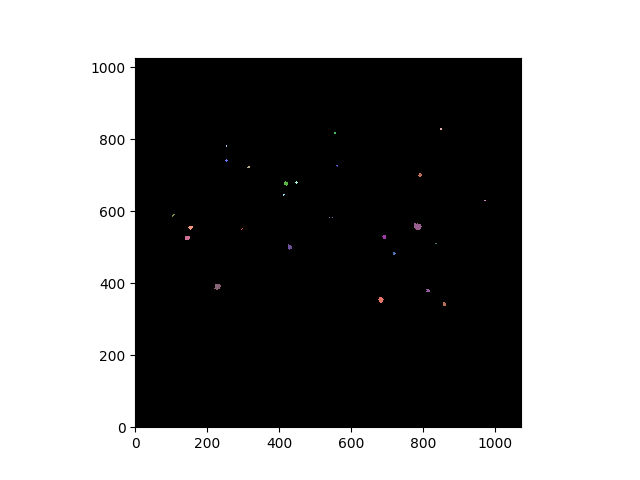

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq-CM-0-UT20231008T093601-3.fits.segm
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      81   (1072, 1027)   int64 (rescales to float64)   


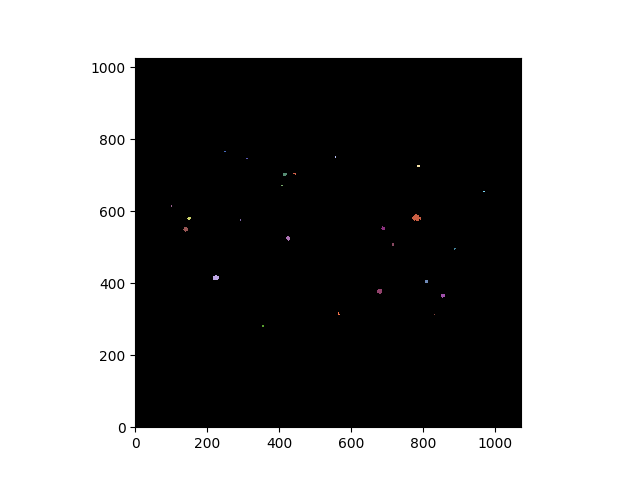

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.segm
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      81   (1072, 1027)   int64 (rescales to float64)   


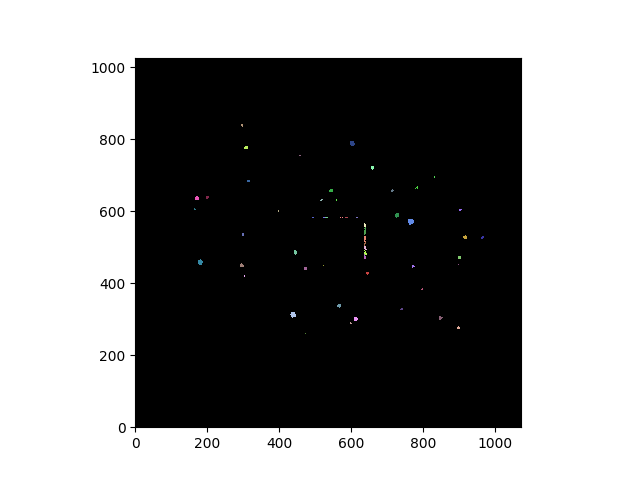

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq-0-1-UT20231008T093616-7.fits.segm
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      81   (1072, 1027)   int64 (rescales to float64)   


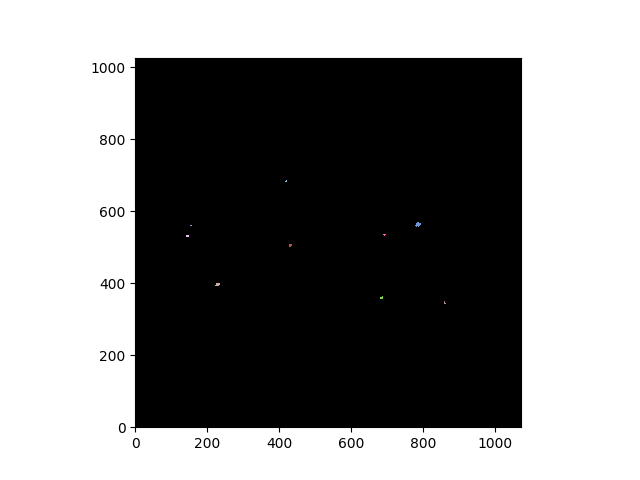

In [391]:
outdir = Path(OUTPUT_DIRS['DET'])
for file in os.listdir(outdir):
    if file.endswith('.segm'):
        segm = Fits(outdir.joinpath(file))
        cmap = load_object(outdir.joinpath(file+'.cmap.pkl'))
        plt.figure(clear=True)
        plt.imshow(segm.data[0], origin='lower', cmap=cmap,interpolation='nearest')
        plt.show()

In [25]:
load_object('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq--UT20231008T093800-5_sources.pkl').get_data()['kron_aperture'][0]

<EllipticalAperture([472.54545524, 259.81814549], a=9.916381467479884, b=6.587426236268861, theta=-0.716112056704075)>

In [361]:
load_object('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/seeing/OBK-530784-WiFeS-Acq--UT20231008T093800-5_sources.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/seeing/OBK-530784-WiFeS-Acq--UT20231008T093800-5_sources.pkl'

In [382]:
data = load_object('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/xmatch/OBK-530784-WiFeS-Acq--UT20231008T093800-5_sources.pkl').get_data()
data['Gal']

FileNotFoundError: [Errno 2] No such file or directory: '/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/xmatch/OBK-530784-WiFeS-Acq--UT20231008T093800-5_sources.pkl'

In [357]:
load_object('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0//OBK-530784-WiFeS-Acq--UT20231008T093800-5_sources.pkl').get_metadata()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/photcal/OBK-530784-WiFeS-Acq--UT20231008T093800-5_sources.pkl'

In [30]:
table = get_table_from_ldac('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/phot/temp_OBK-530784-WiFeS-Acq--UT20231008T093800-5.cat')
table

label,xcentroid,ycentroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr,NUMBER,fwhm,ellipticity,elong,xpos,ypos,xcentroid_win,ycentroid_win,aimage,bimage,THETA_IMAGE,ALPHAWIN_J2000,DELTAWIN_J2000,X_IMAGE,Y_IMAGE,FWHM_IMAGE,FWHM_WORLD,MAG_AUTO,FLAGS,DIFFPATH,SCIPATH,REFPATH,PIXSCALE
,,,,,,,pix2,pix,pix,deg,,,,,,,,,,pix,,,,,,,pix,pix,deg,deg,deg,,,pix,pix,,,,,,
int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes104,bytes1,bytes1,float64
1,472.5454552424737,259.8181454948694,471,474,258,261,11.0,1.133300739140558,0.7528487127164413,-41.030198507576586,0.7474683871626638,4.144411882695774,60.03919901400402,-0.036282179866500064,266.0196351908375,--,562.1126441390593,--,1,2.2654982816208493,0.33570261915882427,1.5053499062930764,472.5454552424737,259.8181454948694,472.5233791076388,259.6661319260594,1.133300739140558,0.7528487127164413,-41.030198507576586,306.6967914398836,10.699227657098195,472.5233791076388,259.6661319260594,2.2654982816208493,0.0001674822924924824,-6.87455838601326,0,/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/background/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits,--,--,7.392735357656387e-05
2,897.8751574926621,274.33930689360466,894,902,270,278,56.0,2.2955524512647285,1.9884406677426492,-15.178933818794881,0.499672446696974,-2.327984902784336,111.56418398583016,-0.29468107290826234,2424.5042754401943,--,3452.6587753146478,--,2,5.056960926938438,0.1337855658026359,1.1544485528304569,897.8751574926621,274.33930689360466,898.093526426648,274.3078514007554,2.2955524512647285,1.9884406677426492,-15.178933818794881,306.69578088037514,10.66803764835201,898.093526426648,274.3078514007554,5.056960926938438,0.0003738477384686461,-8.845384148363811,0,/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/background/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits,--,--,7.392735357656387e-05
3,598.7309015204831,287.7306877139814,596,601,285,290,26.0,1.559302112470444,1.4004542631527435,44.99752095760145,0.43973231756460524,2.0211149985774304,75.31428127715809,-0.2215184947828981,910.4557202942855,--,1861.8761095791342,--,3,3.4898620646613483,0.1018711178849323,1.1134259457785487,598.7309015204831,287.7306877139814,598.9922736843483,287.4142231700751,1.559302112470444,1.4004542631527435,44.99752095760145,306.694715401752,10.689953416483073,598.9922736843483,287.4142231700751,3.4898620646613483,0.0002579962667876567,-8.174876948439021,0,/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/background/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits,--,--,7.392735357656387e-05
4,612.3387571516859,299.31312685038006,606,620,294,305,118.0,3.2366108688101867,2.945918044608149,9.473538057321697,0.4141996670763544,0.9895918609978356,571.5140575233669,-0.006399112158634479,12010.78474708938,--,13180.074492249789,--,4,7.287413438670668,0.08981395539492198,1.0986764804044995,612.3387571516859,299.31312685038006,612.2089371688493,299.122233465616,3.2366108688101867,2.945918044608149,9.473538057321697,306.6938299595337,10.688982194220817,612.2089371688493,299.122233465616,7.287413438670668,0.0005387391899392096,-10.29979466211721,0,/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/background/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits,--,--,7.392735357656387e-05
5,847.3748032781656,302.6000443369928,843,853,298,307,80.0,2.8293339315635144,2.310611692823395,-17.76903966546316,0.5771151670548127,2.0282047444074056,157.05996258753353,-1.172006991437245,4165.331460066117,--,6495.984004927762,--,5,6.082563739556615,0.18333722751964776,1.2244956347928282,847.3748032781656,302.6000443369928,847.1134309593818,302.61097493114244,2.8293339315635144,2.310611692823395,-17.769039

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/psf_model/OBK-530784-WiFeS-Acq--UT20231008T093800-5.psfmodel.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (217, 217)   float64   


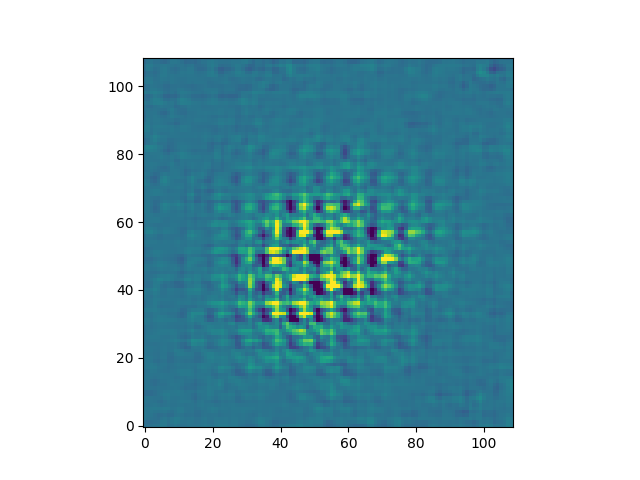

In [332]:
img = Fits('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/psf_model/OBK-530784-WiFeS-Acq--UT20231008T093800-5.psfmodel.fits')

data = img.data[0]
crop = data.shape[0]//4
data = data[crop:-crop,crop:-crop]

norm = simple_norm(data, 'power', percent=99.0)

plt.figure(clear=True)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.show()

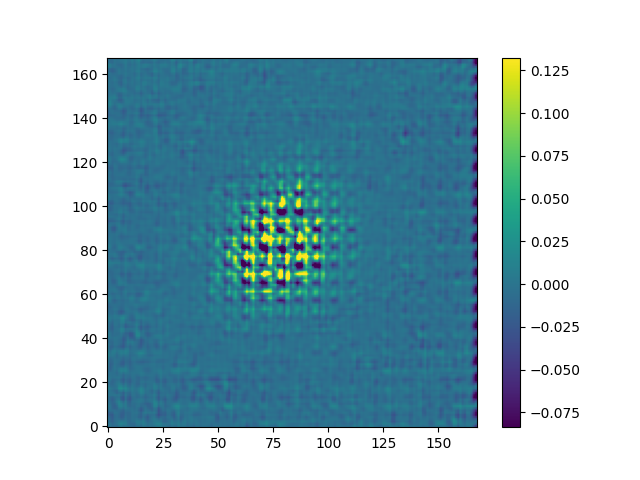

In [335]:
prec = 8
size = 21*prec
x, y = np.mgrid[0:size, 0:size]/prec
center = (size//2/prec,size//2/prec)

psfmodel = load_object('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/psf_model/OBK-530784-WiFeS-Acq--UT20231008T093800-5.psfmodel.pkl')
psf_array = psfmodel.evaluate(x,y,1,*center)

norm = simple_norm(psf_array, 'power', percent=99.0)

plt.figure(clear=True)
plt.imshow(psf_array, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
plt.show()

In [338]:
model = Gaussian2D(
    amplitude=np.max(psf_array),
    x_mean=center[0],
    y_mean=center[1],
    x_stddev=5, 
    y_stddev=5
)
fitter = TRFLSQFitter(calc_uncertainties=True)
fitted_model = fitter(model,x,y,psf_array)
fitted_model

<Gaussian2D(amplitude=0.04239566, x_mean=10.25316539, y_mean=9.69707328, x_stddev=2.20553583, y_stddev=1.82500789, theta=0.70266762)>

In [233]:
# fitted_model.y_fwhm**2


array([ 0.05202883, 10.9064221 , 10.13111339,  1.88858736,  1.53191432,
       15.37836421])

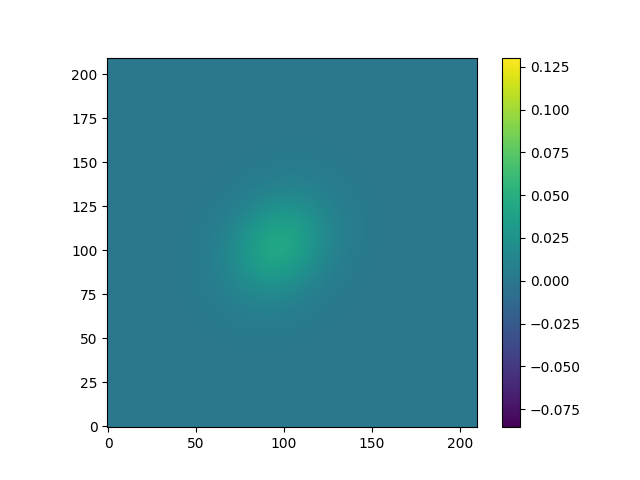

In [319]:
plt.figure(clear=True)
plt.imshow(fitted_model.evaluate(x,y,*fitted_model.parameters), norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
plt.show()

In [320]:
psf_fit_cat = load_object('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/psf_model/OBK-530784-WiFeS-Acq--UT20231008T093800-5_sources.pkl')
pix_scale = psf_fit_cat[PIXSCALE_KEY]

a = fitted_model.x_stddev
b = fitted_model.y_stddev

fwhm_pix = 2*np.sqrt(np.log(2)*(a**2 + b**2))
fwhm_deg = fwhm_pix*pix_scale * u.deg
fwhm_deg.to(u.arcsec)

<Quantity 1.2688097 arcsec>

In [270]:
fx = fitted_model.x_fwhm
fy = fitted_model.y_fwhm

np.sqrt(0.5*(fx**2 + fy**2))

4.049168939252767

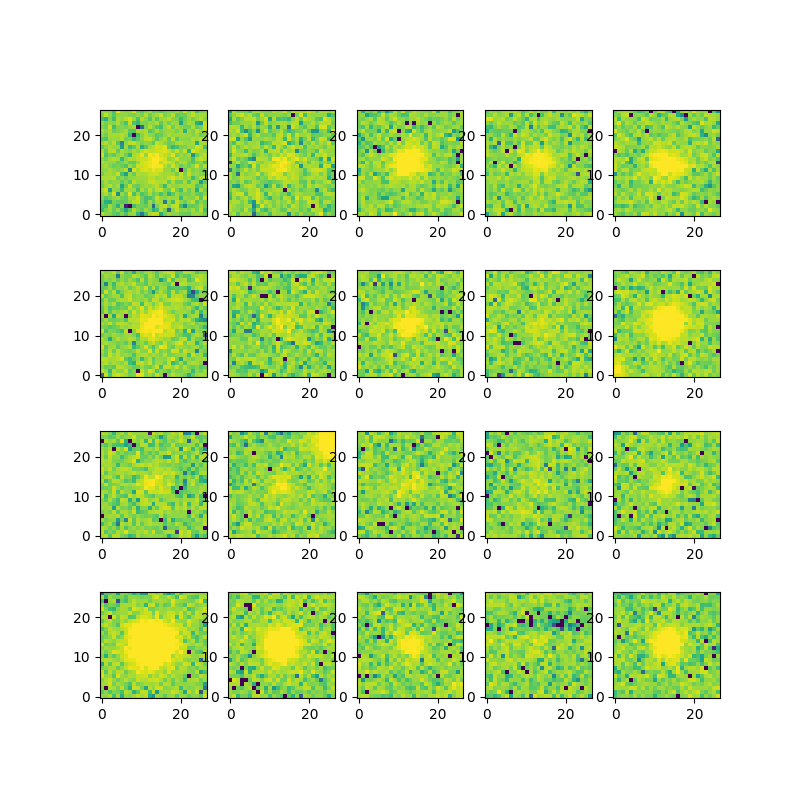

In [299]:
nrows = 4
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8),squeeze=True)

stars = load_object('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/psf_model/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.cutouts.pkl')
stars = stars.all_good_stars

norm = simple_norm(stars[0], 'log', percent=99.0)
ax = ax.ravel()
for i in range(nrows * ncols):
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

In [245]:
fitted_stars = load_object('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/psf_model/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.cutouts.pkl')
fitted_stars.all_good_stars